In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
!pip install jiwer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_cosine_schedule_with_warmup
)
from torch.optim import Adam
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import jiwer
import matplotlib.pyplot as plt
import logging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 90.1 MB/s eta 0:00:00


In [ ]:
# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset - Specify the path to your Chittagong dataset
DATASET_PATH = "/content/drive/MyDrive/Dataset/Chittagong/Chittagong Text Translation.csv"

# Load the dataset
try:
    df = pd.read_csv(DATASET_PATH)
    logger.info(f"Loaded Chittagong dataset with shape: {df.shape}")

    # If column names need renaming, do it here
    if 'Chittagong_Language' in df.columns and 'Standard_Bangla_Language' in df.columns:
        df = df.rename(columns={
            'Chittagong_Language': 'Dialect_Text',
            'Standard_Bangla_Language': 'Standard_Text'
        })

    # Print sample data for verification
    print("Sample data:")
    print(df.head())

except Exception as e:
    logger.error(f"Failed to load dataset: {str(e)}")
    raise

# Define column names
dialect_col = 'Dialect_Text'
standard_col = 'Standard_Text'

# Check for missing values
logger.info("Missing values in each column:")
logger.info(df.isnull().sum())

# Handle missing values
if df[dialect_col].isnull().sum() > 0 or df[standard_col].isnull().sum() > 0:
    df = df.dropna(subset=[dialect_col, standard_col])
    logger.info(f"Dataset shape after removing missing values: {df.shape}")

# Data Preprocessing
def preprocess_text(text):
    """Clean the text by removing extra spaces and trimming"""
    if isinstance(text, str):
        # Remove extra spaces
        text = re.sub(' +', ' ', text)
        # Strip leading and trailing spaces
        return text.strip()
    return ""

# Apply preprocessing
df[dialect_col] = df[dialect_col].apply(preprocess_text)
df[standard_col] = df[standard_col].apply(preprocess_text)

# Remove empty rows
df = df[(df[dialect_col] != "") & (df[standard_col] != "")]
logger.info(f"Dataset shape after preprocessing: {df.shape}")

# Remove duplicates
duplicate_count = df.duplicated(subset=[dialect_col, standard_col]).sum()
if duplicate_count > 0:
    logger.info(f"Found {duplicate_count} duplicate entries")
    df = df.drop_duplicates(subset=[dialect_col, standard_col])
    logger.info(f"Dataset shape after removing duplicates: {df.shape}")


Mounted at /content/drive
Sample data:
                                Dialect_Text  \
0                                   কেন আচো?   
1                      আযিয়া আর মন বালা নাই?   
2                               তুঁই কি গরো?   
3           এই গরমত আত্তুন কিচু বালা ন লাগের   
4  ফোয়াইবা সাদা রংওর উজ্ঞা শার্ট ফরি আইস্যিল   

                             Standard_Text Region_Name  
0                               কেমন আছো ?  Chittagong  
1                    আজকে আমার মন ভালো নেই  Chittagong  
2                            তুমি কি করো ?  Chittagong  
3           এই গরমে আমার কিছু ভালো লাগে না  Chittagong  
4  ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল  Chittagong  


In [ ]:
# Data augmentation: Add reverse translations
def get_augmented_data(df):
    """Create bidirectional translation examples"""
    # Create reverse translations (standard -> dialect)
    reverse_df = df.copy()
    reverse_df[dialect_col], reverse_df[standard_col] = reverse_df[standard_col], reverse_df[dialect_col]

    # Add task prefixes to distinguish direction
    df['task_prefix'] = 'translate dialect to standard:'
    reverse_df['task_prefix'] = 'translate standard to dialect:'

    return pd.concat([df, reverse_df], ignore_index=True)

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Apply augmentation to training data only
augmented_train_df = get_augmented_data(train_df)

logger.info(f"Original train set: {train_df.shape}")
logger.info(f"Augmented train set: {augmented_train_df.shape}")
logger.info(f"Validation set: {val_df.shape}")
logger.info(f"Test set: {test_df.shape}")

In [ ]:

print(f"Original Dataset Shape: {df.shape}")
print(f"Augmented Training Set Shape: {augmented_train_df.shape}")
print(f"Validation Set Shape: {val_df.shape}")
print(f"Test Set Shape: {test_df.shape}")


Original Dataset Shape: (11760, 3)
Augmented Training Set Shape: (16464, 4)
Validation Set Shape: (1764, 3)
Test Set Shape: (1764, 3)


In [ ]:
# Add task prefixes to validation and test sets
val_df['task_prefix'] = 'translate dialect to standard:'
test_df['task_prefix'] = 'translate dialect to standard:'

# Create Dataset class
class DialectDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128,
                 dialect_col='Dialect_Text', standard_col='Standard_Text',
                 task_prefix_col='task_prefix'):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dialect_col = dialect_col
        self.standard_col = standard_col
        self.task_prefix_col = task_prefix_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input_text = self.dataframe.iloc[idx][self.dialect_col]
        target_text = self.dataframe.iloc[idx][self.standard_col]

        # Use dynamic task prefix if available
        if self.task_prefix_col in self.dataframe.columns:
            task_prefix = self.dataframe.iloc[idx][self.task_prefix_col]
            input_text = f"{task_prefix} {input_text}"
        else:
            # Fallback to default prefix
            input_text = f"translate dialect to standard: {input_text}"

        # Tokenize inputs and targets
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Replace padding token id with -100 for loss calculation
        target_ids = target_encoding["input_ids"].squeeze()
        target_ids[target_ids == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": target_ids
        }

In [ ]:
# Load BanglaT5 model and tokenizer
MODEL_NAME = "csebuetnlp/banglat5"
logger.info(f"Loading model: {MODEL_NAME}")

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Create datasets
MAX_LENGTH = 128
train_dataset = DialectDataset(
    augmented_train_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)
val_dataset = DialectDataset(
    val_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)
test_dataset = DialectDataset(
    test_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)

# Create DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Set hyperparameters
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 15 # Reduced from 30 for simplicity, adjust as needed
WARMUP_RATIO = 0.1

In [ ]:
# Set up optimizer with weight decay
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

# Import AdamW optimizer
from transformers import AdamW # Add this line

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

# Calculate training steps
NUM_TRAINING_STEPS = NUM_EPOCHS * len(train_loader)
NUM_WARMUP_STEPS = int(NUM_TRAINING_STEPS * WARMUP_RATIO)

# Use cosine schedule with warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS
)

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    # Return average loss
    return total_loss / len(dataloader)

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Translation function
def translate_text(text, model, tokenizer, device, max_length=128,
                  num_beams=5, task_prefix="translate dialect to standard:"):
    model.eval()

    # Prepare input with task prefix
    input_text = f"{task_prefix} {text}"

    # Tokenize input
    input_encoding = tokenizer(
        input_text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = input_encoding["input_ids"].to(device)
    attention_mask = input_encoding["attention_mask"].to(device)

    # Generate translation
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=num_beams,
            length_penalty=1.0,
            repetition_penalty=1.2,
            early_stopping=True
        )

    # Decode output
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            logger.info(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        logger.info(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, path='drive/MyDrive/best_banglat5_model.pt')

# Training loop with early stopping
train_losses = []
val_losses = []

logger.info(f"Starting training for {NUM_EPOCHS} epochs")
logger.info(f"Model: {MODEL_NAME}")
logger.info(f"Learning rate: {LEARNING_RATE}")
logger.info(f"Batch size: {BATCH_SIZE}")

# Clear GPU memory
torch.cuda.empty_cache()

In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    logger.info(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    logger.info(f"Train loss: {train_loss:.4f}")

    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    logger.info(f"Validation loss: {val_loss:.4f}")

    # Check early stopping
    early_stopping(val_loss, model)

    # Break if early stopping
    if early_stopping.early_stop:
        logger.info("Early stopping triggered")
        break


Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

Training:   0%|          | 0/2058 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/221 [00:00<?, ?it/s]

<ipython-input-15-bb995efbb2d6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


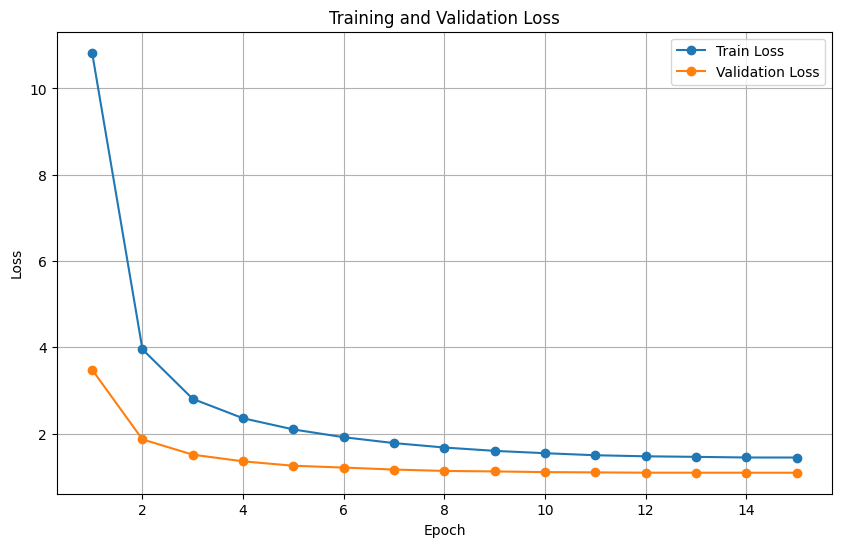

In [ ]:
# Load best model
best_model_path = 'drive/MyDrive/best_banglat5_model.pt'
model.load_state_dict(torch.load(best_model_path))
logger.info(f"Loaded best model from {best_model_path}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('drive/MyDrive/Chittagong_training_loss.png')
plt.show()

In [ ]:
# Calculate metrics functions
def calculate_metrics(original_texts, reference_texts, translated_texts):
    """Calculate BLEU, METEOR, CER, WER scores"""
    # Prepare for BLEU calculation
    references = [[ref.split()] for ref in reference_texts]
    hypotheses = [hyp.split() for hyp in translated_texts]

    # Calculate BLEU scores with different weights
    bleu1_weights = (1, 0, 0, 0)
    bleu2_weights = (0.5, 0.5, 0, 0)
    bleu3_weights = (0.33, 0.33, 0.33, 0)
    bleu4_weights = (0.25, 0.25, 0.25, 0.25)

    bleu1 = corpus_bleu(references, hypotheses, weights=bleu1_weights)
    bleu2 = corpus_bleu(references, hypotheses, weights=bleu2_weights)
    bleu3 = corpus_bleu(references, hypotheses, weights=bleu3_weights)
    bleu4 = corpus_bleu(references, hypotheses, weights=bleu4_weights)

    # Calculate METEOR scores
    meteor_scores = []
    for ref, hyp in zip(references, hypotheses):
        try:
            m_score = meteor_score(ref, hyp)
            meteor_scores.append(m_score)
        except Exception as e:
            logger.warning(f"METEOR calculation error: {str(e)}")
            continue

    meteor_avg = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    # Calculate WER and CER
    wer_scores = []
    cer_scores = []

    for ref, hyp in zip(reference_texts, translated_texts):
        try:
            wer = jiwer.wer(ref, hyp)
            cer = jiwer.cer(ref, hyp)

            wer_scores.append(wer)
            cer_scores.append(cer)
        except Exception as e:
            logger.warning(f"WER/CER calculation error: {str(e)}")
            continue

    avg_wer = sum(wer_scores) / len(wer_scores) if wer_scores else 1.0
    avg_cer = sum(cer_scores) / len(cer_scores) if cer_scores else 1.0

    # Create metrics report
    report = {
        "BLEU-1": bleu1 * 100,
        "BLEU-2": bleu2 * 100,
        "BLEU-3": bleu3 * 100,
        "BLEU-4": bleu4 * 100,
        "METEOR": meteor_avg * 100,
        "WER": avg_wer * 100,
        "CER": avg_cer * 100
    }

    return report

In [ ]:
# Evaluate on test set
logger.info("\nGenerating translations for evaluation metrics...")
original_texts = []
reference_texts = []
translated_texts = []

for idx in tqdm(range(len(test_df))):
    dialect_text = test_df.iloc[idx][dialect_col]
    standard_text = test_df.iloc[idx][standard_col]

    # Generate translation
    translated_text = translate_text(
        dialect_text,
        model,
        tokenizer,
        device
    )

    # Add to lists for evaluation
    original_texts.append(dialect_text)
    reference_texts.append(standard_text)
    translated_texts.append(translated_text)

# Calculate metrics
metrics = calculate_metrics(original_texts, reference_texts, translated_texts)

# Print evaluation metrics
logger.info("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    logger.info(f"{metric}: {value:.2f}")

  0%|          | 0/1764 [00:00<?, ?it/s]

In [ ]:
# Save results to CSV for analysis
results_df = pd.DataFrame({
    'dialect_text': original_texts,
    'reference_text': reference_texts,
    'translated_text': translated_texts
})

# Save only the results CSV, not all intermediate results
results_path = "drive/MyDrive/Chittagong_translation_results.csv"
results_df.to_csv(results_path, index=False)
logger.info(f"Translation results saved to {results_path}")

# Save final model (only once, no checkpoints)
final_model_dir = "drive/MyDrive/Chittagong_translator_final"
import os
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)

model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
logger.info(f"Final model and tokenizer saved to {final_model_dir}")


In [ ]:
# Create a function to translate new text (simple interface for integration)
def translate_dialect_to_standard(text, model=None, tokenizer=None, device=None):

    if model is None or tokenizer is None or device is None:
        # Load model and tokenizer if not provided
        model_dir = "drive/MyDrive/Chittagong_translator_final"
        tokenizer = T5Tokenizer.from_pretrained(model_dir)
        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

    # Preprocess input text
    text = preprocess_text(text)

    # Translate
    return translate_text(
        text,
        model,
        tokenizer,
        device
    )


In [ ]:
# Test with examples
logger.info("\nTesting with examples:")
test_examples = test_df.head(5)  # Just show a few examples
for idx, row in test_examples.iterrows():
    dialect_text = row[dialect_col]
    standard_text = row[standard_col]

    translated_text = translate_dialect_to_standard(dialect_text, model, tokenizer, device)

    logger.info(f"Dialect: {dialect_text}")
    logger.info(f"Expected: {standard_text}")
    logger.info(f"Translated: {translated_text}")
    logger.info("-" * 50)

In [ ]:

logger.info("\nTesting with examples:")
test_examples = test_df.head(30)  # Just show a few examples
results = []
for idx, row in test_examples.iterrows():
    dialect_text = row[dialect_col]
    standard_text = row[standard_col]
    translated_text = translate_dialect_to_standard(dialect_text, model, tokenizer, device)
    results.append({
        "Dialect": dialect_text,
        "Expected": standard_text,
        "Translated": translated_text
    })
    logger.info(f"Dialect: {dialect_text}")
    logger.info(f"Expected: {standard_text}")
    logger.info(f"Translated: {translated_text}")
    logger.info("-" * 50)

# Now you have the results stored in a list of dictionaries
# You can then use the results list for further processing.
import pprint
pprint.pprint(results)


[{'Dialect': 'মাডত-ঘাটত দল বাঁধি খেলা হার',
  'Expected': 'মাঠে-ঘাটে দলবেঁধে খেলাধুলা করে',
  'Translated': 'মাঠে-ঘাটে দল বেঁধে খেলা করি'},
 {'Dialect': 'চলো এক্কোফোয়ারে মাছ দরি',
  'Expected': 'চলো একসাথে মাছ ধরি',
  'Translated': 'চলো একসাথে মাছ ধরি'},
 {'Dialect': 'নোয়া অফিসে',
  'Expected': 'নতুন অফিসে',
  'Translated': 'নতুন অফিসে'},
 {'Dialect': 'এবা বেশি ডোর না',
  'Expected': 'তিনি বেশি লম্বা না',
  'Translated': 'সে বেশি লম্বা না'},
 {'Dialect': 'পার্কর বেঞ্চত',
  'Expected': 'পার্কের বেঞ্চে',
  'Translated': 'পার্কের বেঞ্চে'},
 {'Dialect': 'ফা আরর আগাত উইটত চায়',
  'Expected': 'পাহাড়ের চূড়ায় উঠতে চাই',
  'Translated': 'ছেলেটি আমার কাছে আসতে চায়'},
 {'Dialect': 'রেজালা কি রহম গম লাগে দে?',
  'Expected': 'কোন ধরনের রেজালা পছন্দ?',
  'Translated': 'কোন ধরনের রেজালা পছন্দ?'},
 {'Dialect': 'ফরম্যাট হডে গরিবেন দে?',
  'Expected': 'কোথায় ফরম্যাট করবেন?',
  'Translated': 'কোথায় ফরম্যাট করবেন?'},
 {'Dialect': 'বসন্ত হাল।',
  'Expected': 'বসন্ত কাল।',
  'Translated': 'বসন্ত কাল।'},

In [ ]:
# prompt: I want to called translation function for translation one sentence

# Example usage of the translation function
sentence_to_translate = "আইজ আমার মন ভালা নাই"
translated_sentence = translate_dialect_to_standard(sentence_to_translate, model, tokenizer, device)
print(f"Original sentence: {sentence_to_translate}")
print(f"Translated sentence: {translated_sentence}")


Original sentence: আইজ আমার মন ভালা নাই
Translated sentence: আজ আমার মন ভালো নেই


In [ ]:
# Create a function to zip and download the model for integration
def zip_model_for_download():
    """Zip the model for download and integration with frontend"""
    import shutil
    from google.colab import files

    zip_path = "/content/Chittagong_translator_model.zip"
    shutil.make_archive("/content/Chittagong_translator_model", 'zip', final_model_dir)
    print(f"Model zipped at {zip_path}")

    # Download from Colab
    files.download(zip_path)

# Zip model for download (uncomment to use)
zip_model_for_download()

Model zipped at /content/Chittagong_translator_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\nTraining and evaluation complete!")
print(f"Final model saved to: {final_model_dir}")
print(f"Results saved to: {results_path}")
print("\nUse translate_dialect_to_standard() function for new translations.")


Training and evaluation complete!
Final model saved to: drive/MyDrive/Chittagong_translator_final
Results saved to: drive/MyDrive/Chittagong_translation_results.csv

Use translate_dialect_to_standard() function for new translations.


In [ ]:


# Evaluate on test set
logger.info("\nGenerating translations for evaluation metrics...")
original_texts = []
reference_texts = []
translated_texts = []

for idx in tqdm(range(len(test_df))):
    dialect_text = test_df.iloc[idx][dialect_col]
    standard_text = test_df.iloc[idx][standard_col]

    # Generate translation
    translated_text = translate_text(
        dialect_text,
        model,
        tokenizer,
        device
    )

    # Add to lists for evaluation
    original_texts.append(dialect_text)
    reference_texts.append(standard_text)
    translated_texts.append(translated_text)

# Calculate metrics
metrics = calculate_metrics(original_texts, reference_texts, translated_texts)

# Print evaluation metrics
logger.info("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    logger.info(f"{metric}: {value:.2f}")
    print(f"{metric}: {value:.2f}") # Print to standard output as well




  0%|          | 0/1764 [00:00<?, ?it/s]

BLEU-1: 69.01
BLEU-2: 58.43
BLEU-3: 49.40
BLEU-4: 39.93
METEOR: 62.80
WER: 33.93
CER: 19.77
